
# Experiment Tracking

The machine learning life cycle involves training multiple algorithms using different hyperparameters and libraries, all with different performance results and trained models.  This lesson explores tracking those experiments to organize the machine learning life cycle.

## In this lesson you:<br>
 - Introduce tracking ML experiments in MLflow
 - Log an experiment and explore the results in the UI
 - Record parameters, metrics, and a model
 - Query past runs programatically

Over the machine learning life cycle...<br>

* Data scientists test many different models
* Using various libraries
* Each with different hyperparameters

Tracking these various results poses an organizational challenge, including... <br>

* Storing experiments
* Results
* Models
* Supplementary artifacts
* Code
* Data snapshots


### Tracking Experiments with MLflow

MLflow Tracking is...<br>

* a logging API specific for machine learning
* agnostic to libraries and environments that do the training
* organized around the concept of **runs**, which are executions of data science code
* runs are aggregated into **experiments** where many runs can be a part of a given experiment
* An MLflow server can host many experiments.

Each run can record the following information:<br>

* **Parameters:** Key-value pairs of input parameters such as the number of trees in a random forest model
* **Metrics:** Evaluation metrics such as RMSE or Area Under the ROC Curve
* **Artifacts:** Arbitrary output files in any format.  This can include images, pickled models, and data files
* **Source:** The code that originally ran the experiment

Experiments can be tracked using libraries in Python, R, and Java as well as by using the CLI and REST calls


<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-tracking.png" style="height: 400px; margin: 20px"/></div>

In [0]:
import mlflow.sklearn
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Loading Dataset
housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Start an experiment using mlflow.start_run() and passing it a name for the run
with mlflow.start_run(run_name="Basic RF Run") as run:
    # Create model, train it, and create predictions
    rf = RandomForestRegressor(random_state=42)
    # Train your model
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)

    # Log the model using mlflow.sklearn.log_model()
    mlflow.sklearn.log_model(rf, "random_forest_model")

    # Log the model error using mlflow.log_metric()
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    # mlflow.log_metric("mse", mse)
    # mlflow.log_metric("rmse", rmse)
    # mlflow.log_metric("r2", r2)

    # Multiple metrics
    metrics = {"mse": mse, "rmse": rmse, "r2": r2}
    mlflow.log_metrics(metrics)

    # Print out the run id using run.info.run_id
    run_id = run.info.run_id
    experiment_id = run.info.experiment_id
    
    print(f"Inside MLflow Run with run_id `{run_id}` and experiment_id `{experiment_id}`")

Inside MLflow Run with run_id `84c64af3ab324c259ac41dab29b04ee4` and experiment_id `3112575041154655`


### Parameters, Metrics, and Artifacts

But wait, there's more!  In the last example, you logged the run name, an evaluation metric, and your model itself as an artifact.  Now let's log parameters, multiple metrics, and other artifacts including the feature importances.

First, create a function to perform this.

To log artifacts, we have to save them somewhere before MLflow can log them.  This code accomplishes that by using a temporary file that it then deletes.

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def log_rf(experiment_id, run_name, params, X_train, X_test, y_train, y_test):
  
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        # Create model, train it, and create predictions
        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)
        predictions = rf.predict(X_test)

        # Log model
        mlflow.sklearn.log_model(rf, "random_forest_model")

        # Log params
        mlflow.log_params(params)

        # Log metrics
        mlflow.log_metrics({
            "rmse":np.sqrt(mean_squared_error(y_test, predictions)),
            "mse": mean_squared_error(y_test, predictions), 
            "mae": mean_absolute_error(y_test, predictions), 
            "r2": r2_score(y_test, predictions)
        })

        # Log feature importance
        importance = (pd.DataFrame(list(zip(housing.feature_names, rf.feature_importances_)), columns=["Feature", "Importance"])
                      .sort_values("Importance", ascending=False))
        importance_path = f"/importance.csv"
        importance.to_csv(importance_path, index=False)
        mlflow.log_artifact(importance_path, "feature-importance")

        # Log plot
        fig, ax = plt.subplots(figsize=(10, 4))
        importance.plot.bar(ax=ax)
        ax.set_xticklabels(housing.feature_names, rotation=0)
        plt.title("Feature Importances")
        mlflow.log_figure(fig, "feature_importances.png")

        return run.info.run_id

Run with new parameters.

Out[48]: 'b41d44ee1cde4308a88d9df7011b7a47'

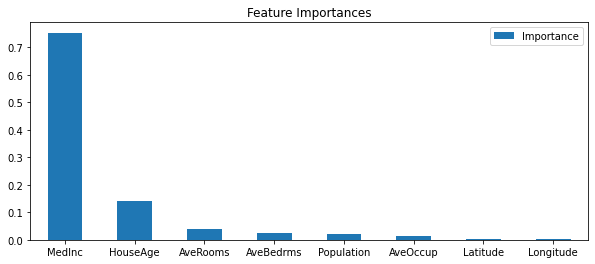

In [0]:
params = {
    "n_estimators": 100,
    "max_depth": 5,
    "random_state": 42
}

log_rf(experiment_id, "Second Run", params, X_train, X_test, y_train, y_test)

Out[49]: '5d5bc56b78964b8790d04adff016e772'

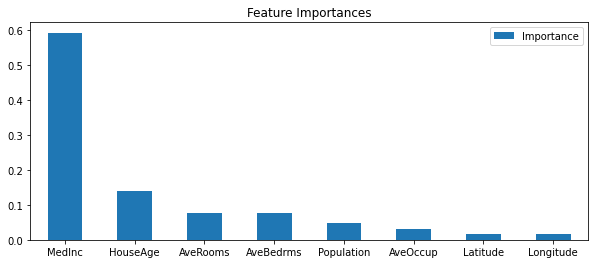

In [0]:
params_1000_trees = {
    "n_estimators": 1000,
    "max_depth": 10,
    "random_state": 42
}

log_rf(experiment_id, "Third Run", params_1000_trees, X_train, X_test, y_train, y_test)


### Querying Past Runs

You can query past runs programatically in order to use this data back in Python.  The pathway to doing this is an **`MlflowClient`** object.

You can also set tags for runs using `client.set_tag(run.info.run_id, "tag_key", "tag_value")`

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()


Now list all the runs for your experiment using **`.search_runs()`**, which takes your **`experiment_id`** as a parameter.

In [0]:
display(client.search_runs(experiment_id))

_data,_info
"List(List(List(r2, 0, 1712033599463, 0.7758174430130119), List(mae, 0, 1712033599463, 0.36456518124498855), List(rmse, 0, 1712033599463, 0.5420063057204697), List(mse, 0, 1712033599463, 0.2937708354407513)), Map(mae -> 0.36456518124498855, r2 -> 0.7758174430130119, rmse -> 0.5420063057204697, mse -> 0.2937708354407513), Map(random_state -> 42, n_estimators -> 1000, max_depth -> 10), Map(mlflow.log-model.history -> [{""artifact_path"":""random_forest_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""},""python_version"":""3.9.5""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.0.2"",""serialization_format"":""cloudpickle"",""code"":null}},""run_id"":""5d5bc56b78964b8790d04adff016e772"",""model_uuid"":""373ad6276b6746ff9a6245d88004d4ef"",""utc_time_created"":""2024-04-02 04:53:12.556888"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}], mlflow.databricks.cluster.libraries -> {""installable"":[],""redacted"":[]}, mlflow.runName -> Third Run, mlflow.databricks.notebook.commandID -> 2997290263024081100_5405370608006583148_d08c0f1a32ea4a70ac69984dfc79aacd, mlflow.databricks.notebookPath -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.databricks.notebookID -> 3112575041154655, mlflow.databricks.notebookRevisionID -> 1712033600288, mlflow.databricks.cluster.id -> 0319-023413-d27nc7x4, mlflow.source.type -> NOTEBOOK, mlflow.databricks.cluster.info -> {""cluster_name"":""Ana María López Moreno's Cluster 12.2"",""spark_version"":""12.2.x-cpu-ml-scala2.12"",""node_type_id"":""Standard_DS3_v2"",""driver_node_type_id"":""Standard_DS3_v2"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"":0}, mlflow.source.name -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.user -> darkanita@gmail.com, mlflow.databricks.workspaceURL -> adb-2495978626582077.17.azuredatabricks.net, mlflow.databricks.workspaceID -> 2495978626582077, mlflow.databricks.webappURL -> https://eastus-c3.azuredatabricks.net))","List(dbfs:/databricks/mlflow-tracking/3112575041154655/5d5bc56b78964b8790d04adff016e772/artifacts, 1712033600101, 3112575041154655, active, 5d5bc56b78964b8790d04adff016e772, Third Run, 5d5bc56b78964b8790d04adff016e772, 1712033517332, FINISHED, )"
"List(List(List(r2, 0, 1712033516128, 0.6468313266166683), List(mae, 0, 1712033516128, 0.490487833363873), List(rmse, 0, 1712033516128, 0.680290673488139), List(mse, 0, 1712033516128, 0.46279540043494566)), Map(mae -> 0.490487833363873, r2 -> 0.6468313266166683, rmse -> 0.680290673488139, mse -> 0.46279540043494566), Map(random_state -> 42, n_estimators -> 100, max_depth -> 5), Map(mlflow.log-model.history -> [{""artifact_path"":""random_forest_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""},""python_version"":""3.9.5""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.0.2"",""serialization_format"":""cloudpickle"",""code"":null}},""run_id"":""b41d44ee1cde4308a88d9df7011b7a47"",""model_uuid"":""de85863a429b47168a18184443675cb9"",""utc_time_created"":""2024-04-02 04:51:52.776200"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}], mlflow.databricks.cluster.libraries -> {""installable"":[],""redacted"":[]}, mlflow.runName -> Second Run, mlflow.databricks.notebook.commandID -> 2997290263024081100_4932060757111714638_6171469208aa49ddbead5954797ed290, mlflow.databricks.notebookPath -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.databricks.notebookID -> 3112575041154655, mlflow.databricks.notebookRevisionID -> 1712033517202, mlflow.databricks.cluster.id -> 0319-023


Pull out a few fields and create a spark DataFrame with it.

In [0]:
runs = spark.read.format("mlflow-experiment").load(experiment_id)
display(runs)

run_id,experiment_id,metrics,params,tags,start_time,end_time,status,artifact_uri
5d5bc56b78964b8790d04adff016e772,3112575041154655,"Map(r2 -> 0.7758174430130119, mae -> 0.36456518124498855, rmse -> 0.5420063057204697, mse -> 0.2937708354407513)","Map(max_depth -> 10, n_estimators -> 1000, random_state -> 42)","Map(mlflow.log-model.history -> [{""artifact_path"":""random_forest_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""},""python_version"":""3.9.5""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.0.2"",""serialization_format"":""cloudpickle"",""code"":null}},""run_id"":""5d5bc56b78964b8790d04adff016e772"",""model_uuid"":""373ad6276b6746ff9a6245d88004d4ef"",""utc_time_created"":""2024-04-02 04:53:12.556888"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}], mlflow.databricks.cluster.libraries -> {""installable"":[],""redacted"":[]}, mlflow.runName -> Third Run, mlflow.databricks.notebook.commandID -> 2997290263024081100_5405370608006583148_d08c0f1a32ea4a70ac69984dfc79aacd, mlflow.databricks.notebookPath -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.databricks.notebookID -> 3112575041154655, mlflow.databricks.notebookRevisionID -> 1712033600288, mlflow.databricks.cluster.id -> 0319-023413-d27nc7x4, mlflow.source.type -> NOTEBOOK, mlflow.databricks.cluster.info -> {""cluster_name"":""Ana María López Moreno's Cluster 12.2"",""spark_version"":""12.2.x-cpu-ml-scala2.12"",""node_type_id"":""Standard_DS3_v2"",""driver_node_type_id"":""Standard_DS3_v2"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"":0}, mlflow.source.name -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.user -> darkanita@gmail.com, mlflow.databricks.workspaceURL -> adb-2495978626582077.17.azuredatabricks.net, mlflow.databricks.workspaceID -> 2495978626582077, mlflow.databricks.webappURL -> https://eastus-c3.azuredatabricks.net)",2024-04-02T04:51:57.332+0000,2024-04-02T04:53:20.101+0000,FINISHED,dbfs:/databricks/mlflow-tracking/3112575041154655/5d5bc56b78964b8790d04adff016e772/artifacts
b41d44ee1cde4308a88d9df7011b7a47,3112575041154655,"Map(r2 -> 0.6468313266166683, mae -> 0.490487833363873, rmse -> 0.680290673488139, mse -> 0.46279540043494566)","Map(max_depth -> 5, n_estimators -> 100, random_state -> 42)","Map(mlflow.log-model.history -> [{""artifact_path"":""random_forest_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""},""python_version"":""3.9.5""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.0.2"",""serialization_format"":""cloudpickle"",""code"":null}},""run_id"":""b41d44ee1cde4308a88d9df7011b7a47"",""model_uuid"":""de85863a429b47168a18184443675cb9"",""utc_time_created"":""2024-04-02 04:51:52.776200"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}], mlflow.databricks.cluster.libraries -> {""installable"":[],""redacted"":[]}, mlflow.runName -> Second Run, mlflow.databricks.notebook.commandID -> 2997290263024081100_4932060757111714638_6171469208aa49ddbead5954797ed290, mlflow.databricks.notebookPath -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.databricks.notebookID -> 3112575041154655, mlflow.databricks.notebookRevisionID -> 1712033517202, mlflow.databricks.cluster.id -> 0319-023413-d27nc7x4, mlflow.source.type -> NOTEBOOK, mlflow.databricks.cluster.info -> {""cluster_name"":""Ana María López Moreno's Cluster 12.2"",""spark_version"":""12.2.x-cpu-ml-scala2.12"",""node_type_id"":""Standard_DS3_v2"",""driver_node_type_id"":""Standard_DS3_v2"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"


Now list all the runs using **`.search_runs()`** defining a condition as a parameter.

In [0]:
search_runs = mlflow.search_runs(
    filter_string="metrics.r2 > 0.7", search_all_experiments=True
)
print(search_runs)

                             run_id  ... tags.mlflow.databricks.cluster.libraries
0  5d5bc56b78964b8790d04adff016e772  ...         {"installable":[],"redacted":[]}
1  06d9ffee49ec4889a7b722b795841299  ...         {"installable":[],"redacted":[]}
2  84c64af3ab324c259ac41dab29b04ee4  ...         {"installable":[],"redacted":[]}
3  cd4ce889e9b84349853917b131b66a7c  ...         {"installable":[],"redacted":[]}
4  4141fc7a7f6b439c86f7c5f4a853785c  ...         {"installable":[],"redacted":[]}

[5 rows x 28 columns]



Pull out a few fields and create a spark DataFrame with it.

In [0]:
runs = spark.read.format("mlflow-experiment").load(experiment_id)
display(runs)

run_id,experiment_id,metrics,params,tags,start_time,end_time,status,artifact_uri
5d5bc56b78964b8790d04adff016e772,3112575041154655,"Map(r2 -> 0.7758174430130119, mae -> 0.36456518124498855, rmse -> 0.5420063057204697, mse -> 0.2937708354407513)","Map(max_depth -> 10, n_estimators -> 1000, random_state -> 42)","Map(mlflow.log-model.history -> [{""artifact_path"":""random_forest_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""},""python_version"":""3.9.5""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.0.2"",""serialization_format"":""cloudpickle"",""code"":null}},""run_id"":""5d5bc56b78964b8790d04adff016e772"",""model_uuid"":""373ad6276b6746ff9a6245d88004d4ef"",""utc_time_created"":""2024-04-02 04:53:12.556888"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}], mlflow.databricks.cluster.libraries -> {""installable"":[],""redacted"":[]}, mlflow.runName -> Third Run, mlflow.databricks.notebook.commandID -> 2997290263024081100_5405370608006583148_d08c0f1a32ea4a70ac69984dfc79aacd, mlflow.databricks.notebookPath -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.databricks.notebookID -> 3112575041154655, mlflow.databricks.notebookRevisionID -> 1712033600288, mlflow.databricks.cluster.id -> 0319-023413-d27nc7x4, mlflow.source.type -> NOTEBOOK, mlflow.databricks.cluster.info -> {""cluster_name"":""Ana María López Moreno's Cluster 12.2"",""spark_version"":""12.2.x-cpu-ml-scala2.12"",""node_type_id"":""Standard_DS3_v2"",""driver_node_type_id"":""Standard_DS3_v2"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"":0}, mlflow.source.name -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.user -> darkanita@gmail.com, mlflow.databricks.workspaceURL -> adb-2495978626582077.17.azuredatabricks.net, mlflow.databricks.workspaceID -> 2495978626582077, mlflow.databricks.webappURL -> https://eastus-c3.azuredatabricks.net)",2024-04-02T04:51:57.332+0000,2024-04-02T04:53:20.101+0000,FINISHED,dbfs:/databricks/mlflow-tracking/3112575041154655/5d5bc56b78964b8790d04adff016e772/artifacts
b41d44ee1cde4308a88d9df7011b7a47,3112575041154655,"Map(r2 -> 0.6468313266166683, mae -> 0.490487833363873, rmse -> 0.680290673488139, mse -> 0.46279540043494566)","Map(max_depth -> 5, n_estimators -> 100, random_state -> 42)","Map(mlflow.log-model.history -> [{""artifact_path"":""random_forest_model"",""flavors"":{""python_function"":{""predict_fn"":""predict"",""model_path"":""model.pkl"",""loader_module"":""mlflow.sklearn"",""env"":{""conda"":""conda.yaml"",""virtualenv"":""python_env.yaml""},""python_version"":""3.9.5""},""sklearn"":{""pickled_model"":""model.pkl"",""sklearn_version"":""1.0.2"",""serialization_format"":""cloudpickle"",""code"":null}},""run_id"":""b41d44ee1cde4308a88d9df7011b7a47"",""model_uuid"":""de85863a429b47168a18184443675cb9"",""utc_time_created"":""2024-04-02 04:51:52.776200"",""mlflow_version"":""2.1.1"",""databricks_runtime"":""12.2.x-cpu-ml-scala2.12""}], mlflow.databricks.cluster.libraries -> {""installable"":[],""redacted"":[]}, mlflow.runName -> Second Run, mlflow.databricks.notebook.commandID -> 2997290263024081100_4932060757111714638_6171469208aa49ddbead5954797ed290, mlflow.databricks.notebookPath -> /Users/darkanita@gmail.com/databricks-training/Sesion 2 - Experiment-Tracking, mlflow.databricks.notebookID -> 3112575041154655, mlflow.databricks.notebookRevisionID -> 1712033517202, mlflow.databricks.cluster.id -> 0319-023413-d27nc7x4, mlflow.source.type -> NOTEBOOK, mlflow.databricks.cluster.info -> {""cluster_name"":""Ana María López Moreno's Cluster 12.2"",""spark_version"":""12.2.x-cpu-ml-scala2.12"",""node_type_id"":""Standard_DS3_v2"",""driver_node_type_id"":""Standard_DS3_v2"",""autotermination_minutes"":120,""disk_spec"":{},""num_workers"


Pull the last run and take a look at the associated artifacts.

In [0]:
run_rf = runs.orderBy("start_time", ascending=False).first()

client.list_artifacts(run_rf.run_id)

Out[57]: [<FileInfo: file_size=None, is_dir=True, path='feature-importance'>,
 <FileInfo: file_size=9438, is_dir=False, path='feature_importances.png'>,
 <FileInfo: file_size=None, is_dir=True, path='random_forest_model'>]

Return the evaluation metrics for the last run.

In [0]:
client.get_run(run_rf.run_id).data.metrics

Out[58]: {'mae': 0.36456518124498855,
 'mse': 0.2937708354407513,
 'r2': 0.7758174430130119,
 'rmse': 0.5420063057204697}




Reload the model and take a look at the feature importance.

In [0]:
model = mlflow.sklearn.load_model(f"runs:/{run_rf.run_id}/random_forest_model")
model.feature_importances_

Out[59]: array([0.59352019, 0.04788196, 0.03080424, 0.01663863, 0.01731635,
       0.1398163 , 0.07730939, 0.07671293])


### Signatures and Input Examples

Previously, when logging a model in MLflow we only logged the model and name for the model artifact with **`.log_model(model, model_name)`**

However, it is a best practice to also log a model signature and input example. This allows for better schema checks and, therefore, integration with automated deployment tools.

**Signature**
* A model signature is just the schema of the input(s) and the output(s) of the model
* We usually get this with the **`infer_schema`** function

**Input Example**
* This is simply a few example inputs to the model 
* This will be converted to JSON and stored in our MLflow run
* It integrates well with MLflow model serving

In general, logging a model with these looks like **`.log_model(model, model_name, signature=signature, input_example=input_example)`**.

Let's look at an example, where we create a **`sklearn`** Random Forest Regressor model and log it with the signature and input example.

In [0]:
import mlflow 
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

with mlflow.start_run(run_name="Signature Example") as run:
    rf = RandomForestRegressor(random_state=42)
    rf_model = rf.fit(X_train, y_train)
    mse = mean_squared_error(rf_model.predict(X_test), y_test)
    mlflow.log_metric("mse", mse)

    # Log the model with signature and input example
    signature = infer_signature(X_train, pd.DataFrame(y_train))
    input_example = X_train[0:3]
    mlflow.sklearn.log_model(rf_model, "rf_model", signature=signature, input_example=input_example)


### Nested Runs

A useful organizational tool provided by MLflow is nested runs. Nested runs allow for parent runs and child runs in a tree structure. In the MLflow UI, you can click on a parent run to expand it and see the child runs. 

Example applications: 
* In **hyperparameter tuning**, you can nest all associated model runs under a parent run to better organize and compare hyperparameters. 
* In **parallel training** many models such as IoT devices, you can better aggregate the models. More information on this can be found <a href="https://databricks.com/blog/2020/05/19/manage-and-scale-machine-learning-models-for-iot-devices.html" target="_blank">here</a>.
* In **iterative training** such as neural networks, you can checkpoint results after **`n`** epochs to save the model and related metrics.

In [0]:
with mlflow.start_run(run_name="Nested Example") as run:
    # Create nested run with nested=True argument
    with mlflow.start_run(run_name="Child 1", nested=True):
        mlflow.log_param("run_name", "child_1")

    with mlflow.start_run(run_name="Child 2", nested=True):
        mlflow.log_param("run_name", "child_2")


### Autologging

So far we have explored methods for manually logging models, parameters, metrics, and artifacts to MLflow. 

However, in some cases it would be convenient to do this automatically. This is where MLflow Autologging comes in. 

Autologging allows you to **log metrics, parameters, and models without the need for explicit log statements.**

There are two ways to enable autologging: 

1. Call mlflow.autolog() before your training code. This will enable autologging for each supported library you have installed as soon as you import it. <a href="https://www.mlflow.org/docs/latest/tracking.html#automatic-logging" target="_blank">A list of supported libraries can be found here</a>.

2. Use library-specific autolog calls for each library you use in your code. For example, enabling mlflow for sklearn specically would use **`mlflow.sklearn.autolog()`**

Let's try our first example again, this time just with autologging. We'll enable autologging for all libraries. 

**NOTE:** We do not need to put the code in a **`mlflow.start_run()`** block.

In [0]:
mlflow.autolog()

rf = RandomForestRegressor(random_state=42)
rf_model = rf.fit(X_train, y_train)

2024/04/02 05:15:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/04/02 05:15:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2024/04/02 05:15:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2024/04/02 05:15:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '20147cf879a3475c9d759f6e008e9569', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow



### Hyperparameter Tuning 

One of the most common use cases for nested runs and autologging is hyperparameter tuning. For example, when running **HyperOpt** with SparkTrials on Databricks, it will automatically track the candidate models, parameters, etc as child runs in the MLflow UI.

Hyperopt allows for efficient hyperparameter tuning and now integrates with Apache Spark via:

* **Trials:** Sequential training of single-node or distributed ML models (e.g. MLlib)
* **SparkTrials:** Parallel training of single-node models (e.g. sklearn). The amount of parallelism is controlled via the **`parallelism`** parameter. 

Let's try using HyperOpt with SparkTrials to find the best sklearn random forest model. 

Check out this blog by Sean Owen on <a href="https://databricks.com/blog/2021/04/15/how-not-to-tune-your-model-with-hyperopt.html" target="_blank">How (Not) to Tune Your Model With Hyperopt</a>.


Set up the Hyperopt run.  We need to define an objective function to minimize and a search space for the parameters for our Hyperopt run. 

Hyperopt will work to minimize the objective function, so here we simply return the **`loss`** as the mse, since that is what we are trying to minimize. 

**Note**: If you're trying to maximize a metric, such as accuracy or r2, you would need to return **`-accuracy`** or **`-r2`** so Hyperopt can minimize it.

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials

# Define objective function
def objective(params):
    model = RandomForestRegressor(n_estimators=int(params["n_estimators"]), 
                                  max_depth=int(params["max_depth"]), 
                                  min_samples_leaf=int(params["min_samples_leaf"]),
                                  min_samples_split=int(params["min_samples_split"]))
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    score = mean_squared_error(pred, y_train)

    # Hyperopt minimizes score, here we minimize mse. 
    return score


Execute the MLflow Hyperopt Run

**Note:** This code uses autologging. When using autologging with Hyperopt, it logs the hyperparameters used but not the model itself. Unlike the example above, the user has to log the best model manually.

In [0]:
from hyperopt import SparkTrials

# Define search space
search_space = {"n_estimators": hp.quniform("n_estimators", 100, 500, 5),
                "max_depth": hp.quniform("max_depth", 5, 20, 1),
                "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 5, 1),
                "min_samples_split": hp.quniform("min_samples_split", 2, 6, 1)}

# Set parallelism (should be order of magnitude smaller than max_evals)
spark_trials = SparkTrials(parallelism=2)

with mlflow.start_run(run_name="Hyperopt"):
    argmin = fmin(fn=objective,
                  space=search_space,
                  algo=tpe.suggest,
                  max_evals=16,
                  trials=spark_trials)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


100%|██████████| 16/16 [04:25<00:00, 16.61s/trial, best loss: 0.06659126799370153]


Total Trials: 16: 16 succeeded, 0 failed, 0 cancelled.



### Advanced Artifact Tracking

In addition to the logging of artifacts you have already seen, there are some more advanced options. 

We will now look at: 
* <a href="https://www.mlflow.org/docs/latest/python_api/mlflow.shap.html#mlflow.shap" target="_blank">mlflow.shap</a>: Automatically calculates and logs Shapley feature importance plots
* <a href="https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_figure" target="_blank">mlflow.log_figure</a>: Logs matplotlib and plotly plots

  0%|          | 0/5 [00:00<?, ?it/s]

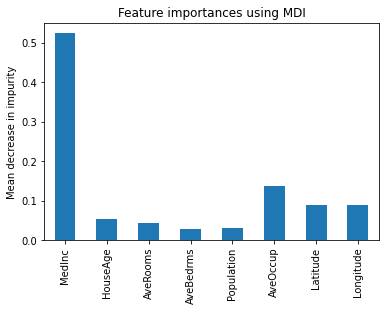

In [0]:
import matplotlib.pyplot as plt

with mlflow.start_run(run_name="Feature Importance Scores"):
    # Generate and log SHAP plot for first 5 records
    mlflow.shap.log_explanation(rf.predict, X_train[:5])

    # Generate feature importance plot
    feature_importances = pd.Series(rf_model.feature_importances_, index=housing.feature_names)
    fig, ax = plt.subplots()
    feature_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

    # Log figure
    mlflow.log_figure(fig, "feature_importance_rf.png")


## Additional Resources

* <a href="http://hyperopt.github.io/hyperopt/" target="_blank">Hyperopt Docs</a>
* <a href="https://databricks.com/blog/2019/06/07/hyperparameter-tuning-with-mlflow-apache-spark-mllib-and-hyperopt.html" target="_blank">Hyperparamter Tuning Blog post</a>
* <a href="https://docs.databricks.com/applications/machine-learning/automl-hyperparam-tuning/hyperopt-spark-mlflow-integration.html#how-to-use-hyperopt-with-sparktrials" target="_blank">Spark Trials Hyperopt Documentation</a>
* <a href="https://www.mlflow.org/docs/latest/python_api/mlflow.shap.html" target="_blank">MLflow Shap Documentation</a>